<img src="../rsag_convex.png" alt="algoconvex" />
<img src="../x_update.png" alt="x_update" />
<img src="../mean.png" alt="mean" />
<img src="../rsag_composite.png" alt="algo" />

__Parameters :__
- $\alpha$: (1-$\alpha$) weight of aggregated x on current state, i.e. momentum
- $\lambda$: learning rate
- $\beta$: change for aggregated x
- $p_k$ termination probability



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import sklearn
from sklearn.neural_network import MLPClassifier

In [19]:
from sklearn.model_selection import KFold
import pandas as pd

import sys
sys.path.append('../')
from util import DataLoader, plot_accuracies


# Data Loading

In [20]:
def preprocess_mnist(valid_split=0.2):
  import random as rand
  from sklearn.model_selection import train_test_split
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")

  assert x_train.shape == (60000, 28, 28)
  assert x_test.shape == (10000, 28, 28)
  assert y_train.shape == (60000,)
  assert y_test.shape == (10000,)

  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat

  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  # finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))

  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)

  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=valid_split, random_state=42)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_mnist(0.2)

# Model Implementation - Softmax

### Metrics

In [21]:
def evaluate_acc(truth, pred):
  counter =0

  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter / float(len(pred))

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

### MLP

In [22]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])
linear = lambda z: np.array([i/float(sum(i)) for i in z])
# logistic = lambda z: 1./ (1 + np.exp(-z))
# relu = lambda y: y[y <= 0]=0
def relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  # x[x<=0]=0.1*x
  np.putmask(x, x<0, alpha*x)
  return x
def relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

In [ ]:
class MLPRelu:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None


    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1)
            z1 = relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = relu(q2)
            yh = softmax2D(np.dot(z2, w))#N
            acc = evaluate_acc(yh,y)
            # print('yShape=', y.shape)

            ## Backpropagation
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M
            ## 2nd Layer
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams, acc

        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01

        if self.params is None:
            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(D, self.num_classes))
            self.params = [w]
            
            print('params initialized')

            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(self.M, self.num_classes))
            v2 = initializer(shape=(self.M, self.M))
            v1 = initializer(shape=(D, self.M))
            self.params = [v1, v2,w]
            if self.rsag:
                self.aggr_params = [np.copy(v1), np.copy(v2), np.copy(w)]

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, batch_train_acc

    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

In [23]:
class MLP_2_Layer_Softmax:

    def __init__(self, M = 128, num_classes = 10, rsag=False):
        self.M = M
        self.num_classes = num_classes
        self.rsag = rsag
        self.params = None
        self.aggr_params = None

    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            w = params[0] # v.shape = (D, M), w.shape = (M)
            z = np.dot(x, w)
            yh = softmax2D(z)#N
            dy = yh - y #N
            train_acc = evaluate_acc(y, yh)

            # Softmax Gradient
            dw = np.dot(x.T, dy)/N #M
            dparams = [dw]
            return dparams, train_acc
        
        if self.params is None:
            initializer = keras.initializers.GlorotNormal()
            w = initializer(shape=(D, self.num_classes))
            self.params = [w]
            if self.rsag:
                self.aggr_params = [np.copy(w)]
            print('params initialized')

        if self.rsag:
            self.params, self.aggr_params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params, self.aggr_params)
        else:
            self.params, train_accs, batch_train_acc = optimizer.mini_batch_step(gradient, x, y, self.params)

        return self, train_accs, batch_train_acc

    def predict(self, x):
        # print('self:',self)
        # print('self==None:',self==None)
        w = self.params[0]
        # print(w.shape)
        # z = relu(np.dot(x, w)) #N x M
        yh = softmax2D(np.dot(x, w))#N
        return yh

# RSAG

In [24]:
lr_lamda = lambda lr, t: lr/(1+t)

In [25]:
def train_model(model, 
                optimizer, 
                x_train, 
                y_train, 
                x_valid, 
                y_valid, 
                verbose=True, 
                print_every=10, 
                patience=20,
                save_log=False):
    # x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    # model.fit(x_train, y_train, optimizer)

    # y_test_pred = model.predict(x_valid)
    # temp_v_acc = evaluate_acc(y_test_pred, y_valid)
    # v_acc = [temp_v_acc]

    # print('acc:',temp_v_acc)
    log = {'loss': [], 'accuracy': [], 'v_loss': [], 'v_accuracy': [], 'time': []}
    t=0
    log['time'].append(time.time())
    curr_patience = 0
    accept_update = (optimizer.lr_fn is not None) or (optimizer.alpha_fn is not None) or (optimizer.beta_fn is not None)


    while t < optimizer.max_iters:
        
        model.fit(x_train, y_train, optimizer)

        log['accuracy'].append(evaluate_acc(y_train, model.predict(x_train)))
        log['loss'].append(log_loss(y_train, model.predict(x_train)))

        y_valid_pred = model.predict(x_valid)
        temp_v_acc = evaluate_acc(y_valid, y_valid_pred)
        log['v_accuracy'].append(temp_v_acc)
        log['v_loss'].append(log_loss(y_valid, y_valid_pred))
        
        if verbose:
            if t%print_every == 0:
                print('Epoch {}/{}'.format(t, optimizer.max_iters))
                print('-' * 10)
                print('Loss {:.4f}'.format(log['loss'][-1]))
                print('Accuracy:  {:.4f}'.format(log['accuracy'][-1]))
                print('Validation Loss {:.4f}'.format(log['v_loss'][-1]))
                print('Validation Accuracy:  {:.4f}'.format(log['v_accuracy'][-1]))
                print('Time :', log['time'][-1]-log['time'][0])
        
        log['time'].append(time.time())

        if len(log['v_accuracy']) > 1 and (np.abs(log['v_accuracy'][-1]-log['v_accuracy'][-2])<0.001):
            curr_patience += 1
            if curr_patience > patience:
                if accept_update:
                    print()
                    optimizer.set_update_params(True)
                    curr_patience = 0
                else:
                    print('Early stopping at epoch %d'%t)
                    break
        else:
            curr_patience = 0
        t+=1
    if verbose:
        print(log)
    # if save_log == True:
    #     np.save('log.csv', log)
    return model, log, max(log['v_accuracy'])

In [59]:
class RSAG:

    def __init__(self, 
                 learning_rate=.001, 
                 alpha=0.009, 
                 beta=.000009, 
                 max_iters=2000, 
                 epsilon=1e-8, 
                 batch_size=64,
                 lr_fn = None,
                    alpha_fn = None,
                    beta_fn = None,
                    start_adap = 30,
                 ):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.alpha = alpha  # momentum param
        self.beta = beta 

        self.lr_fn = lr_fn
        self.alpha_fn = alpha_fn
        self.beta_fn = beta_fn

        self.update_params = False

        self.t = 0


    def set_update_params(self, update_params):
        self.update_params = update_params

    def mini_batch_step(self, 
                       gradient_fn,
                       x, 
                       y,
                       params, 
                       agg_params,
                       ):
        
        train_acc, batch_train_acc, chunk = [], [], []


        slices = sklearn.utils.gen_batches(x.shape[0], self.batch_size)


        if self.update_params:
            print('Update params')
            if self.lr_fn is not None:
                self.learning_rate = self.lr_fn(self.learning_rate, self.t)
                # print('New learning rate:', self.learning_rate)
            if self.alpha_fn is not None:
                self.alpha = self.alpha_fn(self.alpha, self.t)
                # print('New alpha:', self.alpha)
            if self.beta_fn is not None:
                self.beta = self.beta_fn(self.beta, self.t)
                # print('New beta:', self.beta)
            self.update_params = False

        grad = None
        for batch in slices:
            x_temp, y_temp = x[batch], y[batch]

            proj_params = [(1-self.alpha) * a_p + self.alpha * p for p, a_p in zip(params, agg_params)]

            grad, temp_acc = gradient_fn(x_temp, y_temp, proj_params)

            chunk.append(temp_acc)
            train_acc.append( ( self.t, temp_acc ) )

            for p in range(len(params)):
                agg_params[p] -= self.beta * (grad[p])
                params[p] -= self.learning_rate * (grad[p])

            
        self.t += 1
            
        return params, agg_params, train_acc, batch_train_acc

## Constant Learning Rate

In [40]:
from sklearn.neural_network import MLPClassifier
adam_clf = MLPClassifier(hidden_layer_sizes=(512,), activation='relu', solver='adam', alpha=0.0001, batch_size=64, learning_rate='constant', learning_rate_init=0.0009,verbose=True)
%time adam_clf.fit(x_train, y_train)
print(adam_clf.loss_curve_)

Iteration 1, loss = 0.56689042
Iteration 2, loss = 0.22338052
Iteration 3, loss = 0.15295820
Iteration 4, loss = 0.11181460
Iteration 5, loss = 0.08360399
Iteration 6, loss = 0.06272007
Iteration 7, loss = 0.04801744
Iteration 8, loss = 0.03659672
Iteration 9, loss = 0.02881842
Iteration 10, loss = 0.02291506
Iteration 11, loss = 0.01850346
Iteration 12, loss = 0.01606156
Iteration 13, loss = 0.01460083
Iteration 14, loss = 0.01306851
Iteration 15, loss = 0.01431100
Iteration 16, loss = 0.01395232
Iteration 17, loss = 0.00945815
Iteration 18, loss = 0.00631575
Iteration 19, loss = 0.00605234
Iteration 20, loss = 0.02729778
Iteration 21, loss = 0.01305690
Iteration 22, loss = 0.00687241
Iteration 23, loss = 0.00685696
Iteration 24, loss = 0.01332954
Iteration 25, loss = 0.01212407
Iteration 26, loss = 0.00819130
Iteration 27, loss = 0.00872882
Iteration 28, loss = 0.00857303
Iteration 29, loss = 0.01842043
Iteration 30, loss = 0.01136303
Training loss did not improve more than tol=0.000

In [28]:
n_clf = MLPClassifier(hidden_layer_sizes=(512,), activation='relu', solver='sgd', alpha=0.0001, momentum=0.009, batch_size=64, learning_rate='constant', learning_rate_init=0.09, nesterovs_momentum=True,verbose=True)
%time n_clf.fit(x_train, y_train)
print(n_clf.loss_curve_)

Iteration 1, loss = 0.44759780
Iteration 2, loss = 0.19962974
Iteration 3, loss = 0.13763680
Iteration 4, loss = 0.10054675
Iteration 5, loss = 0.07573810
Iteration 6, loss = 0.05655920
Iteration 7, loss = 0.04262150
Iteration 8, loss = 0.03194773
Iteration 9, loss = 0.02439345
Iteration 10, loss = 0.01884822
Iteration 11, loss = 0.01548255
Iteration 12, loss = 0.01284822
Iteration 13, loss = 0.01081867
Iteration 14, loss = 0.00927849
Iteration 15, loss = 0.00834193
Iteration 16, loss = 0.00756359
Iteration 17, loss = 0.00697681
Iteration 18, loss = 0.00641268
Iteration 19, loss = 0.00599621
Iteration 20, loss = 0.00564703
Iteration 21, loss = 0.00534162
Iteration 22, loss = 0.00509163
Iteration 23, loss = 0.00488330
Iteration 24, loss = 0.00469081
Iteration 25, loss = 0.00451049
Iteration 26, loss = 0.00435061
Iteration 27, loss = 0.00421886
Iteration 28, loss = 0.00409721
Iteration 29, loss = 0.00399346
Iteration 30, loss = 0.00388553
Iteration 31, loss = 0.00381891
Iteration 32, los

MLPClassifier(batch_size=64, hidden_layer_sizes=(512,), learning_rate_init=0.09,
              momentum=0.8, solver='sgd', verbose=True)

In [60]:
model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.009, alpha=0.9, beta=0.00009)
model, log, acc_max = train_model(model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/2000
----------
Loss 2.3266
Accuracy:  0.1651
Validation Loss 2.3296
Validation Accuracy:  0.1599
Time : 0.0
Epoch 10/2000
----------
Loss 2.2310
Accuracy:  0.2342
Validation Loss 2.2345
Validation Accuracy:  0.2263
Time : 36.7719943523407
Epoch 20/2000
----------
Loss 2.1409
Accuracy:  0.2914
Validation Loss 2.1448
Validation Accuracy:  0.2814
Time : 72.07000017166138
Epoch 30/2000
----------
Loss 2.0564
Accuracy:  0.3434
Validation Loss 2.0606
Validation Accuracy:  0.3377
Time : 107.09100031852722
Epoch 40/2000
----------
Loss 1.9771
Accuracy:  0.3905
Validation Loss 1.9817
Validation Accuracy:  0.3857
Time : 141.65803241729736
Epoch 50/2000
----------
Loss 1.9030
Accuracy:  0.4359
Validation Loss 1.9078
Validation Accuracy:  0.4294
Time : 175.48403406143188
Epoch 60/2000
----------
Loss 1.8339
Accuracy:  0.4752
Validation Loss 1.8389
Validation Accuracy:  0.4698
Time : 209.12503218650818
Epoch 70/2000
----------
Loss 1.7695
Accuracy:  0.5097
Validation Los

In [81]:
print('Nesterov\'s Momentum: ', accuracy_score(y_test, n_clf.predict(x_test)))
print('Adam', accuracy_score(y_test, adam_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, model.predict(x_test)))



Nesterov's Momentum:  0.9665
RSAG:  0.7206


## Adaptive Rates

In [35]:
from sklearn.neural_network import MLPClassifier
ada_adam_clf = MLPClassifier(hidden_layer_sizes=(512,), 
                    activation='relu', 
                    solver='adam', 
                    alpha=0.0001, 
                    batch_size=64, 
                    learning_rate='adaptive', learning_rate_init=0.009, 
                    verbose=True)
%time ada_adam_clf.fit(x_train, y_train)
print(ada_adam_clf.loss_curve_)
# 0.

Iteration 1, loss = 0.55972425
Iteration 2, loss = 0.39162685
Iteration 3, loss = 0.34236851
Iteration 4, loss = 0.30131580
Iteration 5, loss = 0.29043969
Iteration 6, loss = 0.25807719
Iteration 7, loss = 0.27122241
Iteration 8, loss = 0.25729660
Iteration 9, loss = 0.25205371
Iteration 10, loss = 0.26798882
Iteration 11, loss = 0.25168944
Iteration 12, loss = 0.23677867
Iteration 13, loss = 0.24399048
Iteration 14, loss = 0.24848356
Iteration 15, loss = 0.24139524
Iteration 16, loss = 0.22773300
Iteration 17, loss = 0.21861714
Iteration 18, loss = 0.25072565
Iteration 19, loss = 0.24090263
Iteration 20, loss = 0.22283594
Iteration 21, loss = 0.21955865
Iteration 22, loss = 0.23879643
Iteration 23, loss = 0.24880807
Iteration 24, loss = 0.23509450
Iteration 25, loss = 0.23507097
Iteration 26, loss = 0.24293878
Iteration 27, loss = 0.21893924
Iteration 28, loss = 0.22958057
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
CPU times: total: 10min

In [37]:
from sklearn.neural_network import MLPClassifier
ada_n_clf = MLPClassifier(hidden_layer_sizes=(512,), 
                    activation='relu', 
                    solver='sgd', 
                    nesterovs_momentum=True, momentum=0.8, 
                    alpha=0.0001, 
                    batch_size=64, 
                    learning_rate='adaptive', learning_rate_init=0.09, 
                    verbose=True)
%time ada_n_clf.fit(x_train, y_train)
print(ada_n_clf.loss_curve_)
# [0.44681103581513676, 0.20019664490280964, 0.13903224539205372, 0.10424847724141931, 0.07820499920454431, 0.058752163212104365, 0.043410302283061385, 0.03309851304613901, 0.024876101979232398, 0.01929008625679405, 0.015819937931698343, 0.013119976535614704, 0.010973030088508333, 0.009540544547209177, 0.008448110407638392, 0.007664338032747635, 0.007013316780792199, 0.006486374157175714, 0.006095292770812613, 0.005675877345495901, 0.0054022429375176085, 0.00513810528301851, 0.004894300819477778, 0.0046914968425572304, 0.004521968420409352, 0.004382123050836891, 0.004225336735758417, 0.004105947003241883, 0.004022477045464209, 0.00391625698267327, 0.00381627076430297, 0.003734125082134867, 0.0036585145164223704, 0.0035892765943956887, 0.003535108147590659, 0.0034728889894520094, 0.003423243203272597, 0.0033613748221156515, 0.0033209246686070446, 0.0032750012111578595, 0.0032428164285514404, 0.0031472642626693514, 0.00313540047623953, 0.0031274728038711342, 0.0031212632827213012, 0.003114252978888586, 0.0031080337824674776, 0.003101702468251574, 0.0030953610962955085, 0.0030896990514066754, 0.0030833365283901883, 0.0030782073457771234, 0.0030617350283354996, 0.003060549141933265, 0.0030593253836724964, 0.0030581476059231704, 0.0030570752884987, 0.0030559063233432083, 0.0030547919126509217, 0.0030536457900612515, 0.003052595325926041, 0.003051489594663097, 0.003050402807525037, 0.003047089985460461, 0.0030468709101408916, 0.00304664551618608, 0.0030464373152081815, 0.0030462080789324364, 0.0030459880671757436, 0.0030457771840295507, 0.003045556586654198, 0.0030453388259683405, 0.003045121461271467, 0.0030449053634260008, 0.003044243744314005, 0.003044199859050067, 0.0030441554267542706, 0.003044113223247068, 0.0030440669153180746, 0.003044024809002121, 0.0030439809670705074, 0.003043937660844538, 0.003043893460652599, 0.0030438492201060137, 0.0030438063584988352, 0.0030436746449449643, 0.0030436661456755966, 0.003043657153375949, 0.0030436483079828943, 0.0030436399384663215, 0.003043631149097291, 0.0030436226278294947, 0.0030436140071533023, 0.0030436051023823587, 0.003043596657471788, 0.0030435877939500645, 0.0030435612724777723, 0.003043559480786767, 0.0030435576795176137, 0.0030435559909718557, 0.0030435543156908484, 0.0030435524919245087, 0.0030435508733789004, 0.0030435490561886423, 0.0030435473792563687, 0.0030435455905639722, 0.003043543878271781, 0.003043538543579084, 0.003043538195354039, 0.0030435378405210514, 0.003043537500316023, 0.003043537158119788, 0.0030435368009090824, 0.0030435364589390434, 0.0030435361249210625, 0.003043535774513943, 0.0030435354281969276, 0.003043535068763328, 0.003043534007049275, 0.0030435339380192826, 0.0030435338680986786, 0.003043533801818329, 0.0030435337274862567, 0.0030435336587934713, 0.003043533590966916, 0.0030435335231968684, 0.0030435334535933857, 0.0030435333838051744, 0.0030435333118708843]

Iteration 1, loss = 0.44629569
Iteration 2, loss = 0.19761935
Iteration 3, loss = 0.13851662
Iteration 4, loss = 0.10198125
Iteration 5, loss = 0.07565146
Iteration 6, loss = 0.05732416
Iteration 7, loss = 0.04264194
Iteration 8, loss = 0.03113957
Iteration 9, loss = 0.02404643
Iteration 10, loss = 0.01882680
Iteration 11, loss = 0.01499647
Iteration 12, loss = 0.01257564
Iteration 13, loss = 0.01070930
Iteration 14, loss = 0.00931212
Iteration 15, loss = 0.00828146
Iteration 16, loss = 0.00745348
Iteration 17, loss = 0.00694460
Iteration 18, loss = 0.00637148
Iteration 19, loss = 0.00592012
Iteration 20, loss = 0.00561063
Iteration 21, loss = 0.00529541
Iteration 22, loss = 0.00507472
Iteration 23, loss = 0.00482877
Iteration 24, loss = 0.00466486
Iteration 25, loss = 0.00449134
Iteration 26, loss = 0.00434099
Iteration 27, loss = 0.00421523
Iteration 28, loss = 0.00409368
Iteration 29, loss = 0.00398979
Iteration 30, loss = 0.00389631
Iteration 31, loss = 0.00379851
Iteration 32, los

In [61]:
ada_model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)
optimizer = RSAG(learning_rate=.09, alpha=0.009, beta=0.00009,
                lr_fn=lr_lamda, alpha_fn=lr_lamda, beta_fn=lr_lamda, 
                start_adap=49)
ada_model, ada_log, acc_max = train_model(ada_model, optimizer, x_train, y_train, x_valid, y_valid, print_every=10)

params initialized
Epoch 0/2000
----------
Loss 2.2635
Accuracy:  0.1395
Validation Loss 2.2578
Validation Accuracy:  0.1454
Time : 0.0
Epoch 10/2000
----------
Loss 1.4811
Accuracy:  0.6134
Validation Loss 1.4807
Validation Accuracy:  0.6159
Time : 35.26599931716919
Epoch 20/2000
----------
Loss 1.0738
Accuracy:  0.6889
Validation Loss 1.0748
Validation Accuracy:  0.6867
Time : 69.30499839782715
Epoch 30/2000
----------
Loss 0.9021
Accuracy:  0.7117
Validation Loss 0.9043
Validation Accuracy:  0.7076
Time : 102.21599841117859
Epoch 40/2000
----------
Loss 0.8467
Accuracy:  0.7213
Validation Loss 0.8510
Validation Accuracy:  0.7185
Time : 135.04899859428406
Epoch 50/2000
----------
Loss 0.8506
Accuracy:  0.7260
Validation Loss 0.8575
Validation Accuracy:  0.7233
Time : 168.36103796958923
Update params
Epoch 60/2000
----------
Loss 0.8822
Accuracy:  0.7290
Validation Loss 0.8917
Validation Accuracy:  0.7268
Time : 201.21799969673157
Epoch 70/2000
----------
Loss 0.8830
Accuracy:  0.7291

KeyboardInterrupt: 

In [63]:
print('Adam: ', accuracy_score(y_test, adam_clf.predict(x_test)))
print('Nesterov\'s Momentum: ', accuracy_score(y_test, n_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, model.predict(x_test)))

Adam:  0.9615
Nesterov's Momentum:  0.9659
RSAG:  0.7475


In [43]:
print('Adam: ', accuracy_score(y_test, ada_adam_clf.predict(x_test)))
print('Nesterov\'s Momentum: ', accuracy_score(y_test, ada_n_clf.predict(x_test)))
print('RSAG: ', evaluate_acc(y_test, ada_model.predict(x_test)))

Adam:  0.9547
Nesterov's Momentum:  0.9645
RSAG:  0.7426


In [67]:
adam_avg_epoch_time = (12*60+18)/30
n_avg_epoch_time = (13*60+21)/129
rsag_avg_epoch_time = (12*60+3)/192 # rerun with time

ada_adam_avg_epoch_time = (10*60+11)/28
ada_n_avg_epoch_time = (42*60+17)/129
ada_rsag_avg_epoch_time = (11*60+48)/192
print('Adam', adam_avg_epoch_time)
print('N ', n_avg_epoch_time)
print('RSAG', rsag_avg_epoch_time)
print('Adam', ada_adam_avg_epoch_time)
print('N ', ada_n_avg_epoch_time)
print('RSAG', ada_rsag_avg_epoch_time)

Adam 24.6
N  6.209302325581396
RSAG 3.765625
Adam 21.821428571428573
N  19.666666666666668
RSAG 3.6875


In [64]:
losses = [adam_clf.loss_curve_, n_clf.loss_curve_, log['v_loss'], ada_adam_clf.loss_curve_,ada_n_clf.loss_curve_, ada_log['v_loss']]
epoch_time = [adam_avg_epoch_time, n_avg_epoch_time, rsag_avg_epoch_time, ada_adam_avg_epoch_time, ada_n_avg_epoch_time, ada_rsag_avg_epoch_time]

times = []
for t, l in zip(epoch_time, losses):
    times.append([t*i for i in range(len(l))])



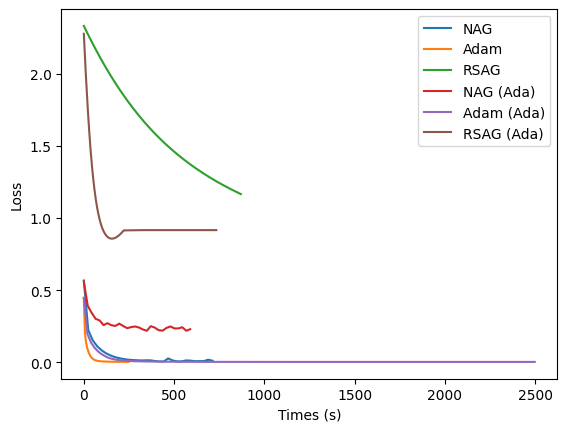

In [66]:
def plot_adjusted_loss(logs, y, labels):
    for log, t, label in zip(logs,y,labels):
        plt.plot(t, log, label=label)
        plt.xlabel('Times (s)')
        plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_adjusted_loss(losses, times,['NAG', 'Adam', 'RSAG', 'NAG (Ada)', 'Adam (Ada)', 'RSAG (Ada)'])

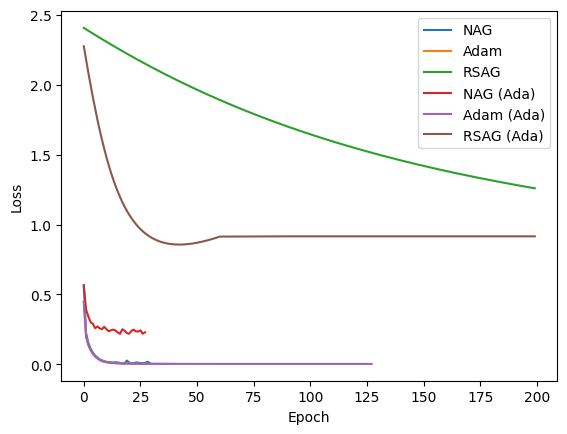

In [58]:
plot_losses([adam_clf.loss_curve_, n_clf.loss_curve_, log['v_loss'], ada_adam_clf.loss_curve_,ada_n_clf.loss_curve_, ada_log['v_loss']], ['NAG', 'Adam', 'RSAG', 'NAG (Ada)', 'Adam (Ada)', 'RSAG (Ada)'])

# Plots

In [56]:
def plot_losses(logs, labels):
    for log, label in zip(logs,labels):
        plt.plot(range(len(log)), log, label=label)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracies_vs_time(logs):
    for log in logs:
        plt.plot(log['v_accuracy'], log['time'], label=log['label'])
        plt.xlabel('Time (s)')
        plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

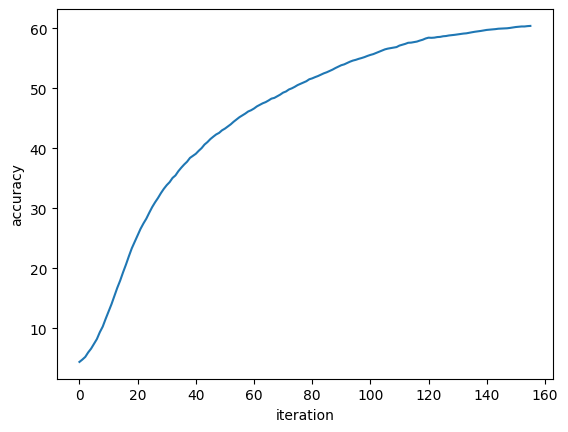

In [41]:
plot_accuracies(log['v_accuracy'])

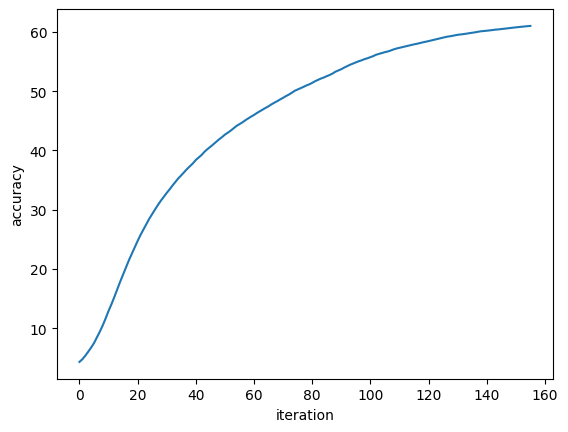

In [42]:
plot_accuracies(log['accuracy'])

In [ ]:
#earning_rate=.006, alpha=0.009, beta=0.000009 {'loss': [2.5160519958632497, 2.4973575056239055, 2.478812720935548, 2.460418367816293, 2.4421750728527756, 2.424083243209927, 2.406143218943164, 2.388355619024832, 2.370720531779371, 2.3532388507830846, 2.3359103385579245, 2.3187356583615517, 2.3017151449607045, 2.284848798003, 2.268137113025858, 2.251580131464062, 2.2351781560975392, 2.2189313277624816, 2.2028397324627114, 2.186903482608769, 2.171122576020296, 2.1554971802396707, 2.1400273974261985, 2.12471322420883, 2.1095543291442924, 2.0945509674032827, 2.0797030372028, 2.0650101785621415, 2.0504724696688656, 2.0360895385965785, 2.021861265377499, 2.007787395317621, 1.9938677452480706, 1.9801019385579555, 1.9664896459769876, 1.9530305341659135, 1.9397243989520938, 1.9265708088428968, 1.913569264293767, 1.9007191856791694, 1.8880201770698002, 1.8754717765074902, 1.8630734839007053, 1.8508246629653273, 1.8387247167204983, 1.8267731012263388, 1.8149689028182607, 1.8033118168215017, 1.7918008676058652, 1.780435443199607, 1.7692147867065802, 1.758138262094848, 1.7472050244117556, 1.736414184032042, 1.725764925254068, 1.7152563634988953, 1.704887640485752, 1.6946577872277346, 1.6845660798988868, 1.6746114205550002, 1.6647928081632135, 1.655109453942081, 1.6455602044679913, 1.63614411612935, 1.6268601594469219, 1.6177073423341959, 1.6086844168984595, 1.5997904959232623, 1.5910244241810505, 1.5823851782440828, 1.573871518177679, 1.5654824421577596, 1.557216748641881, 1.5490733628087985, 1.5410510119995289, 1.5331486888063552, 1.5253652436822294, 1.5176995752563607, 1.5101503292857068, 1.5027163181320302, 1.4953964058131015, 1.4881894832016638, 1.481094316008594, 1.4741097819182238, 1.4672346230198323, 1.4604677039683713, 1.453807736800002, 1.4472536140469547, 1.440804143388772, 1.4344579918486622, 1.4282141241856425, 1.4220714320677037, 1.4160285570580309, 1.4100845667564426, 1.4042380347574344, 1.3984878527799462, 1.392832983561538, 1.3872721741401781, 1.3818042746328631, 1.3764282049267276, 1.3711428537472001, 1.3659470475748883, 1.3608397097045988, 1.3558197165376955, 1.350885922540901, 1.3460371923663124, 1.3412725411089275, 1.336590902774661, 1.3319911511496636, 1.3274722697497163, 1.3230331517395404, 1.3186727883587195, 1.3143902311457627, 1.3101844006747139, 1.3060542439016587, 1.3019988505028786, 1.2980171772661853, 1.2941082629039047, 1.2902711788933614, 1.2865049123578411, 1.2828085680651276, 1.2791812381756231, 1.2756219102534354, 1.2721297229491526, 1.2687038625549176, 1.2653433682122233, 1.2620473589301207, 1.2588149634015926, 1.2556453335623932, 1.2525376170849052, 1.2494910262907375, 1.246504696143371, 1.243577830703593, 1.2407096924293133, 1.237899363279785, 1.2351462232563044, 1.2324494032576179, 1.229808122809259, 1.2272217424748364, 1.2246893998625108, 1.2222104309766801, 1.2197840963234217, 1.217409798994363, 1.2150867337041764, 1.2128142780481603, 1.210591738654992, 1.2084184182913702, 1.206293681621064, 1.2042168761799936, 1.2021873765389202, 1.2002045784726234, 1.1982678221929342, 1.196376580417403, 1.1945301193133262, 1.1927279806807676, 1.1909695424957498], 'accuracy': [4.3, 4.75, 5.341666666666667, 6.0125, 6.716666666666667, 7.477083333333334, 8.441666666666666, 9.40625, 10.4625, 11.641666666666667, 12.902083333333334, 14.0375, 15.26875, 16.56875, 17.841666666666665, 19.060416666666665, 20.266666666666666, 21.464583333333334, 22.55, 23.65625, 24.722916666666666, 25.739583333333332, 26.658333333333335, 27.55625, 28.470833333333335, 29.266666666666666, 30.05, 30.80625, 31.525, 32.172916666666666, 32.829166666666666, 33.43541666666667, 34.08125, 34.6875, 35.295833333333334, 35.80416666666667, 36.35208333333333, 36.87291666666667, 37.33541666666667, 37.81875, 38.385416666666664, 38.81666666666667, 39.24166666666667, 39.78333333333333, 40.22708333333333, 40.6125, 41.02291666666667, 41.4625, 41.87708333333333, 42.24375, 42.66875, 42.99375, 43.34375, 43.729166666666664, 44.1375, 44.43333333333333, 44.73125, 45.083333333333336, 45.395833333333336, 45.71041666666667, 45.989583333333336, 46.31875, 46.610416666666666, 46.895833333333336, 47.1875, 47.45625, 47.77916666666667, 48.0625, 48.31875, 48.614583333333336, 48.88125, 49.175, 49.43333333333333, 49.735416666666666, 50.07083333333333, 50.28958333333333, 50.49583333333333, 50.725, 50.96666666666667, 51.15625, 51.40625, 51.68333333333333, 51.90833333333333, 52.135416666666664, 52.3125, 52.53541666666667, 52.7375, 52.979166666666664, 53.29375, 53.49375, 53.708333333333336, 53.983333333333334, 54.22083333333333, 54.46041666666667, 54.65833333333333, 54.86875, 55.05625, 55.2125, 55.416666666666664, 55.55833333333333, 55.74166666666667, 55.927083333333336, 56.15833333333333, 56.30416666666667, 56.458333333333336, 56.58958333333333, 56.704166666666666, 56.86875, 57.05416666666667, 57.204166666666666, 57.33125, 57.43958333333333, 57.56041666666667, 57.670833333333334, 57.791666666666664, 57.90625, 58.00208333333333, 58.12708333333333, 58.24166666666667, 58.34583333333333, 58.454166666666666, 58.575, 58.7, 58.81458333333333, 58.9375, 59.06041666666667, 59.1625, 59.2375, 59.327083333333334, 59.427083333333336, 59.516666666666666, 59.577083333333334, 59.6375, 59.72291666666667, 59.78958333333333, 59.85625, 59.94166666666667, 60.03333333333333, 60.11666666666667, 60.15416666666667, 60.208333333333336, 60.260416666666664, 60.322916666666664, 60.39375, 60.43125, 60.49166666666667, 60.55833333333333, 60.63125, 60.677083333333336, 60.73125, 60.77708333333333, 60.83125, 60.90416666666667, 60.94583333333333, 60.979166666666664, 61.01875], 'v_loss': [2.5148063596832437, 2.49615115174158, 2.477645865095786, 2.459291206852179, 2.4410877930084904, 2.423036027156197, 2.4051362327818278, 2.3873890088997767, 2.369794446786681, 2.3523534307749725, 2.3350657023587504, 2.317931923993111, 2.3009524178478657, 2.2841271702453367, 2.267456656406367, 2.2509409248654566, 2.234580261467171, 2.218374792645572, 2.2023246052354963, 2.1864297853873835, 2.1706903345144157, 2.1551064139866174, 2.1396780997641, 2.1244053980517505, 2.109287957373581, 2.0943260345083266, 2.0795195103309645, 2.064868031715993, 2.050371651931761, 2.036030004501688, 2.0218429533263245, 2.007810240884165, 1.9939316872527018, 1.9802069020080229, 1.9666355495342172, 1.9532172950622861, 1.9399519304682387, 1.9268390158325168, 1.9138780509548645, 1.9010684523960792, 1.8884098183659395, 1.8759016882093311, 1.8635435585499627, 1.8513347910801574, 1.839274781648382, 1.8273629929940471, 1.8155985062359348, 1.8039810073094362, 1.7925095340134105, 1.7811834604671386, 1.7700020314668363, 1.7589646178779323, 1.7480703688756496, 1.7373183974596424, 1.7267078812669163, 1.716237935998055, 1.7059077065490273, 1.695716225615338, 1.6856627558836956, 1.6757462147164703, 1.6659655958825723, 1.6563201089086288, 1.646808603382893, 1.6374301328060965, 1.6281836675477173, 1.6190682167844326, 1.6100825409944048, 1.6012257423668843, 1.5924966624999113, 1.5838942853757854, 1.575417371423427, 1.5670649123915237, 1.5588357061659899, 1.550728687265933, 1.5427425655045626, 1.5348763544970312, 1.527128887522649, 1.519499066906007, 1.5119855398998892, 1.5045871159380524, 1.4973026538189615, 1.490131047626756, 1.4830710600306156, 1.4761215594216688, 1.4692813007763483, 1.4625491384682816, 1.4559237849669846, 1.4494041271107097, 1.4429889762008965, 1.4366769980378882, 1.4304671523642343, 1.4243583229909194, 1.4183491562713653, 1.4124387104299518, 1.4066255652717912, 1.4009086091516714, 1.3952867979658947, 1.3897588798909377, 1.3843236980094316, 1.3789801723933008, 1.3737271927204455, 1.3685635673111576, 1.3634882249170845, 1.3585000468824315, 1.3535978732176912, 1.3487805759161873, 1.3440471659343356, 1.3393965670122039, 1.334827656155502, 1.3303394145720735, 1.3259307271746612, 1.3216005858707518, 1.317348036777376, 1.3131720032899277, 1.309071424047942, 1.3050453893105254, 1.3010928511784616, 1.2972128510397276, 1.2934044490677945, 1.2896666332736608, 1.2859985116232655, 1.2823991680248932, 1.2788675915936247, 1.2754029178727024, 1.2720043281895772, 1.268670861721328, 1.265401637638159, 1.2621957819253145, 1.2590524413181323, 1.2559707630679149, 1.2529499631767145, 1.2499891689371267, 1.2470875881754835, 1.244244475245979, 1.2414589177784916, 1.2387302947582481, 1.236057727017808, 1.2334404448858396, 1.2308778046353446, 1.2283689407638467, 1.225913188960611, 1.2235098051851063, 1.2211581990139224, 1.2188575695573516, 1.2166072748931558, 1.2144066429936986, 1.2122549648512528, 1.2101516076721892, 1.2080959183405033, 1.2060872707084564, 1.2041250600952305, 1.2022086331282513, 1.200337453655215, 1.1985107994263455, 1.196728201150955, 1.1949890517948278], 'v_accuracy': [4.375, 4.766666666666667, 5.208333333333333, 5.958333333333333, 6.583333333333333, 7.383333333333334, 8.191666666666666, 9.325, 10.258333333333333, 11.541666666666666, 12.758333333333333, 13.975, 15.366666666666667, 16.716666666666665, 17.933333333333334, 19.316666666666666, 20.608333333333334, 22.0, 23.316666666666666, 24.391666666666666, 25.433333333333334, 26.55, 27.45, 28.258333333333333, 29.241666666666667, 30.175, 30.975, 31.691666666666666, 32.5, 33.21666666666667, 33.833333333333336, 34.333333333333336, 35.03333333333333, 35.45, 36.15833333333333, 36.74166666666667, 37.275, 37.74166666666667, 38.375, 38.725, 39.05833333333333, 39.55833333333333, 40.00833333333333, 40.6, 41.00833333333333, 41.50833333333333, 41.90833333333333, 42.28333333333333, 42.541666666666664, 42.96666666666667, 43.25, 43.608333333333334, 43.96666666666667, 44.4, 44.775, 45.15833333333333, 45.45, 45.75833333333333, 46.108333333333334, 46.31666666666667, 46.6, 46.958333333333336, 47.225, 47.475, 47.666666666666664, 47.94166666666667, 48.25, 48.375, 48.65, 48.916666666666664, 49.25, 49.44166666666667, 49.775, 49.96666666666667, 50.21666666666667, 50.50833333333333, 50.725, 50.94166666666667, 51.15, 51.475, 51.625, 51.833333333333336, 52.016666666666666, 52.233333333333334, 52.46666666666667, 52.641666666666666, 52.858333333333334, 53.083333333333336, 53.35, 53.575, 53.81666666666667, 53.958333333333336, 54.19166666666667, 54.40833333333333, 54.59166666666667, 54.71666666666667, 54.88333333333333, 55.016666666666666, 55.175, 55.36666666666667, 55.53333333333333, 55.666666666666664, 55.86666666666667, 56.083333333333336, 56.25833333333333, 56.458333333333336, 56.583333333333336, 56.666666666666664, 56.75, 56.84166666666667, 57.09166666666667, 57.233333333333334, 57.375, 57.55833333333333, 57.583333333333336, 57.675, 57.75833333333333, 57.925, 58.06666666666667, 58.275, 58.40833333333333, 58.38333333333333, 58.416666666666664, 58.50833333333333, 58.541666666666664, 58.641666666666666, 58.68333333333333, 58.775, 58.825, 58.88333333333333, 58.958333333333336, 59.025, 59.09166666666667, 59.13333333333333, 59.233333333333334, 59.31666666666667, 59.4, 59.458333333333336, 59.53333333333333, 59.625, 59.7, 59.74166666666667, 59.791666666666664, 59.833333333333336, 59.9, 59.925, 59.958333333333336, 59.975, 60.03333333333333, 60.11666666666667, 60.18333333333333, 60.225, 60.275, 60.275, 60.333333333333336, 60.36666666666667], 'time': [1703873184.3395016, 1703873188.1885018, 1703873191.74653, 1703873195.4125347, 1703873199.2805028, 1703873202.8574984, 1703873206.4135027, 1703873210.0285332, 1703873213.625532, 1703873217.2345355, 1703873220.821503, 1703873224.4305027, 1703873228.0215025, 1703873231.798522, 1703873235.4224987, 1703873239.0034986, 1703873242.5375032, 1703873246.0975373, 1703873249.9974995, 1703873254.0204985, 1703873258.798502, 1703873262.692498, 1703873266.701503, 1703873270.7034998, 1703873274.7695308, 1703873278.6334984, 1703873282.3705359, 1703873286.2105021, 1703873290.109498, 1703873293.7004986, 1703873297.371504, 1703873301.2295046, 1703873304.8285036, 1703873308.6995306, 1703873312.2875292, 1703873315.8975368, 1703873319.5065024, 1703873323.0665357, 1703873326.6325352, 1703873330.499538, 1703873334.1755025, 1703873337.9205039, 1703873341.6715, 1703873345.343499, 1703873348.9994996, 1703873352.5794983, 1703873356.132502, 1703873359.725535, 1703873363.306537, 1703873366.9655333, 1703873370.5275023, 1703873374.052503, 1703873377.6445022, 1703873381.2025008, 1703873384.742531, 1703873388.2855005, 1703873391.8815331, 1703873395.3805366, 1703873398.9334984, 1703873402.4845045, 1703873405.994503, 1703873409.5765352, 1703873413.1555355, 1703873416.692539, 1703873420.2695358, 1703873423.8435357, 1703873427.3725035, 1703873430.9085355, 1703873434.4765043, 1703873437.997501, 1703873441.5085018, 1703873445.0425003, 1703873448.5775356, 1703873452.145503, 1703873455.6915019, 1703873459.1914992, 1703873462.7075346, 1703873466.2524981, 1703873469.7525358, 1703873473.298503, 1703873476.8185337, 1703873480.4035356, 1703873483.9434988, 1703873487.502501, 1703873491.0235026, 1703873494.4624977, 1703873498.008499, 1703873501.5634985, 1703873505.1045027, 1703873508.6104982, 1703873512.1935358, 1703873515.6935427, 1703873519.198533, 1703873522.7155004, 1703873526.2585351, 1703873529.9525323, 1703873533.793535, 1703873537.4435356, 1703873541.0405002, 1703873544.5664992, 1703873548.0734975, 1703873551.5734987, 1703873555.0594978, 1703873558.5574987, 1703873562.0594985, 1703873565.543498, 1703873569.099536, 1703873572.6095374, 1703873576.113501, 1703873579.635535, 1703873583.1325357, 1703873586.6285028, 1703873590.1265025, 1703873593.6285346, 1703873597.2464995, 1703873600.768535, 1703873604.358533, 1703873607.8424993, 1703873611.3244975, 1703873614.7965043, 1703873618.399499, 1703873621.9274986, 1703873625.4225006, 1703873628.9004989, 1703873632.4055023, 1703873635.9894989, 1703873639.458503, 1703873642.9644985, 1703873646.4784985, 1703873649.9695032, 1703873653.4464984, 1703873656.9505029, 1703873660.4524977, 1703873663.9995322, 1703873667.4694974, 1703873670.9974983, 1703873674.495502, 1703873677.9714994, 1703873681.4595375, 1703873684.906499, 1703873688.8154988, 1703873692.9855366, 1703873696.9705014, 1703873700.941535, 1703873704.7325015, 1703873708.6955342, 1703873712.2925386, 1703873715.8814983, 1703873719.3925016, 1703873722.964502, 1703873726.4614983, 1703873730.088498, 1703873733.6855006, 1703873737.2135024, 1703873740.731503, 1703873744.236503, 1703873747.6925356]}


In [245]:
def hyper_tuning(x_train, y_train, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  momentum = [0.9, 0.99, 0.75, 0.5]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      for mom in momentum:
        print('--------New Model----------')
        print(f"learning rate: {lr}\t Batch Size:{btch}\t Momentum:{mom}")

        optimizer = GradientDescent(learning_rate = lr, batch_size=btch, momentum=mom, lr_lamda=lr_fn)
        
        avg_acc = 0;       
        # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
        start = time.time()
        for k, (train, test) in enumerate(kf.split(x_train, y_train)):
            print('k:',k)
            temp_model = MLP(M=128)
            temp_model, log, temp_acc = train_model(temp_model, optimizer, x_train[train], y_train[train])
            avg_acc += temp_acc
        avg_acc = avg_acc/5
        acc_vals.append(avg_acc)
        end = time.time()
        print('time elapsed:',(end-start)/60/60,"hrs")
        print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [246]:
def hyper_tuning_gd(x_train, y_train, print_every=100, lr_fn=None):
  from sklearn.model_selection import KFold
  import pandas as pd
  kf = KFold(5)
  acc_vals = []
  # hidden_units = [64, 128, 256, 512]
  # activations = [relu] #,leaky_relu, tanh ]
  learning_rate = [0.001, 0.002, 0.004]
  batch_size = [16, 32, 64]
  for btch in batch_size:
    print('batchsize:',btch)
    for lr in learning_rate:
      
      
      print('--------New Model----------')
      print(f"learning rate: {lr}\t Batch Size:{btch}")

      optimizer = GradientDescent(learning_rate = lr, batch_size=btch, lr_fn=lr_fn)
      
      avg_acc = 0;       
      # print(f"for M=128, nonlinearity={activ}, lr={lr}, batch size={btch}.")
      start = time.time()
      for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
          print('k:',k)
          temp_model = MLP(M=128)
          temp_model, log, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], print_every=print_every)
          avg_acc += max_acc
      avg_acc = avg_acc/5
      acc_vals.append(avg_acc)
      end = time.time()
      print('time elapsed:',(end-start)/60/60,"hrs")
      print('acc:',avg_acc)
      
  data = {'learningRate' : [0.001, 0.002, 0.004, 0.001, 0.002, 0.004, 0.001, 0.002, 0.004], 
          'batchSize':[16, 16, 16, 32, 32, 32, 64, 64, 64],
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [248]:
hyper_tuning_gd(x_train=x_train[:10000], y_train=y_train[:10000], print_every=10)


batchsize: 16
--------New Model----------
learning rate: 0.001	 Batch Size:16
k: 0
params initialized
acc: 9.6
Epoch 0: 9.6%
Epoch 100: 9.65%
Epoch 200: 9.65%
Epoch 300: 9.65%


KeyboardInterrupt: 

In [15]:
def hyper_tuning_rsag(x_train, 
                      y_train ,
                      x_valid=None,
                      y_valid=None,
                      adaptive=False,
                      convex=False,
                      ):

  nb_folds = 5
  kf = KFold(nb_folds)
  acc_vals = []

  # learning_rate = [0.3, 0.09, 0.01]
  learning_rate = [0.005, 0.009, 0.001]
  alphas = [.9, .09, .009, .0009]
  betas = [.09, .009, 0.00009]
  
  for alpha in alphas:
    print('alpha:',alpha)
    for beta in betas:
        for lr in learning_rate:
            print('--------New Model----------')
            print(f"learning rate: {lr}\t alpha: {alpha}\t beta:{beta}")
            if adaptive:
                optimizer = RSAG(learning_rate = lr, 
                                 alpha=alpha, 
                                 beta=beta, 
                                 batch_size=64, 
                                 lr_fn=lr_lamda,
                                 alpha_fn=lr_lamda,
                                 beta_fn=lr_lamda)
            else:
              optimizer = RSAG(learning_rate = lr, alpha=alpha, beta=beta, batch_size=64)

            avg_acc = 0;       
            start = time.time()
            for k, (train, valid) in enumerate(kf.split(x_train, y_train)):
                print('k:',k)

                if convex:
                  temp_model = MLP_1_Layer_Linear(M=128, num_classes=10, rsag=True)
                else:
                  temp_model = MLP_2_Layer_Softmax(M=128, num_classes=10, rsag=True)

                temp_model, temp_accs, max_acc = train_model(temp_model, optimizer, x_train[train], y_train[train], x_train[valid], y_train[valid], verbose=False)
                print(f'Fold {k} max acc: {max_acc}')
                avg_acc += max_acc
            
            avg_acc = avg_acc/nb_folds
            acc_vals.append(avg_acc)
            end = time.time()
            print('time elapsed:',(end-start)/60/60,"hrs")
            print('acc:',avg_acc)
            
  data = {'learningRate' : (([0.3]*len(betas))*len(alphas)).append(([0.09]*len(betas))*len(alphas)).append(([0.01]*len(betas))*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)).append([0.001]*len(betas)*len(alphas)).append([0.002]*len(betas)*len(alphas)).append([0.004]*len(betas)*len(alphas)),
          'alpha':[.9]*len(betas).append([.09]*len(betas)).append([.009]*len(betas)).append([.0009]*len(betas))*len(learning_rate),
          'beta':[.001, .002, 0.004]*len(alphas)*len(learning_rate),
          'accuracies': acc_vals
          }
  acc = pd.DataFrame(data)
  print(acc)
  return acc

In [17]:
# 0.009	 alpha: 0.9	 beta:9e-05 .7339
# 0.009	 alpha: 0.09	 beta:0.009
# learning rate: 0.009	 alpha: 0.009	 beta:0.009
# learning rate: 0.009	 alpha: 0.0009	 beta:0.009
hyper_tuning_rsag(x_train=x_train[:2000], y_train=y_train[:2000], adaptive=False) #, x_valid=x_train[2000:2200], y_valid=y_train[2000:2200])

alpha: 0.9
--------New Model----------
learning rate: 0.005	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.5575
k: 1
params initialized
Fold 1 max acc: 0.58
k: 2
params initialized
Fold 2 max acc: 0.6225
k: 3
params initialized
Fold 3 max acc: 0.535
k: 4
params initialized
Fold 4 max acc: 0.6625
time elapsed: 0.026808643407291836 hrs
acc: 0.5915
--------New Model----------
learning rate: 0.009	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.7275
k: 1
params initialized
Fold 1 max acc: 0.695
k: 2
params initialized
Fold 2 max acc: 0.7025
k: 3
params initialized
Fold 3 max acc: 0.705
k: 4
params initialized
Fold 4 max acc: 0.7725
time elapsed: 0.028314995235866967 hrs
acc: 0.7205
--------New Model----------
learning rate: 0.001	 alpha: 0.9	 beta:0.09
k: 0
params initialized
Fold 0 max acc: 0.2025
k: 1
params initialized
Early stopping at epoch 155
Fold 1 max acc: 0.125
k: 2
params initialized
Fold 2 max acc: 0.1775
k: 3
params initialized
Fold 3 max acc

AttributeError: 'NoneType' object has no attribute 'append'